# Data Preprocessing
This notebook describes the preprocessing steps and a quick exploratory analysis:

In [1]:
import pandas as pd
import networkx as nx
import ast
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Loading the data:

In [2]:
data = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
data.head()

,language,sentence,n,edgelist,root
0,Japanese,2,23,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...",10
1,Japanese,5,18,"[(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...",10
2,Japanese,8,33,"[(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...",3
3,Japanese,11,30,"[(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...",30
4,Japanese,12,19,"[(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...",11


Next we check the types and nulls values per column of the training data. No null values are found:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  10500 non-null  object
 1   sentence  10500 non-null  int64 
 2   n         10500 non-null  int64 
 3   edgelist  10500 non-null  object
 4   root      10500 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 410.3+ KB


Now we can check some basic statistics of the numeric columns.
- On average each sentence has $18.8$ words
- The root predicted node can be from the 1st till the 68th node (depending the size of the sentence)

In [4]:
data.describe()

,sentence,n,root
count,10500.000000,10500.000000,10500.000000
mean,494.778000,18.807524,9.844476
std,290.256632,8.190593,7.207740
min,2.000000,3.000000,1.000000
25%,233.500000,13.000000,4.000000
50%,483.000000,18.000000,8.000000
75%,742.250000,23.000000,14.000000
max,995.000000,70.000000,68.000000


In the training data we can find 21 languages with 500 sentences for each language, producing $10,500$ total rows of the training data:

In [5]:
print('Total languages: ' + str(data[['language']].value_counts().shape[0]))
data[['language']].value_counts()

Total languages: 21


language  
Arabic        500
Chinese       500
Czech         500
English       500
Finnish       500
French        500
Galician      500
German        500
Hindi         500
Icelandic     500
Indonesian    500
Italian       500
Japanese      500
Korean        500
Polish        500
Portuguese    500
Russian       500
Spanish       500
Swedish       500
Thai          500
Turkish       500
Name: count, dtype: int64

Now we can visualize the distribution of words per sentence:

Text(0.5, 0, 'Words in sentence')

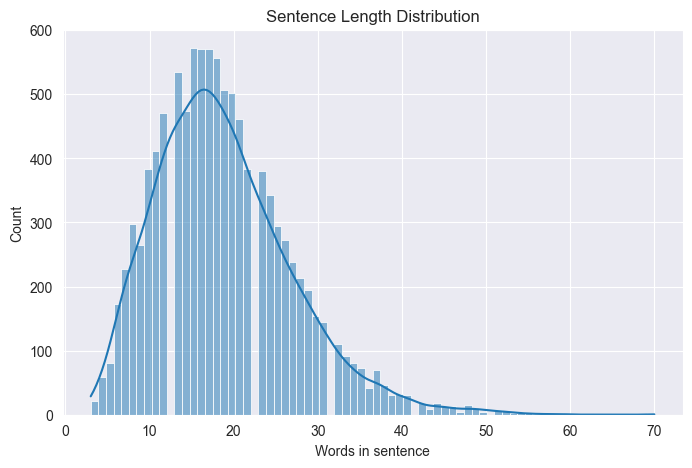

In [6]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
sns.histplot(data=data, x="n", kde=True)
plt.title('Sentence Length Distribution')
plt.ylabel('Count')
plt.xlabel('Words in sentence')


However, not every language follows the same distribution. Different languages follow different distributions since even for the same sentences, they may depict the words in an alternative way:

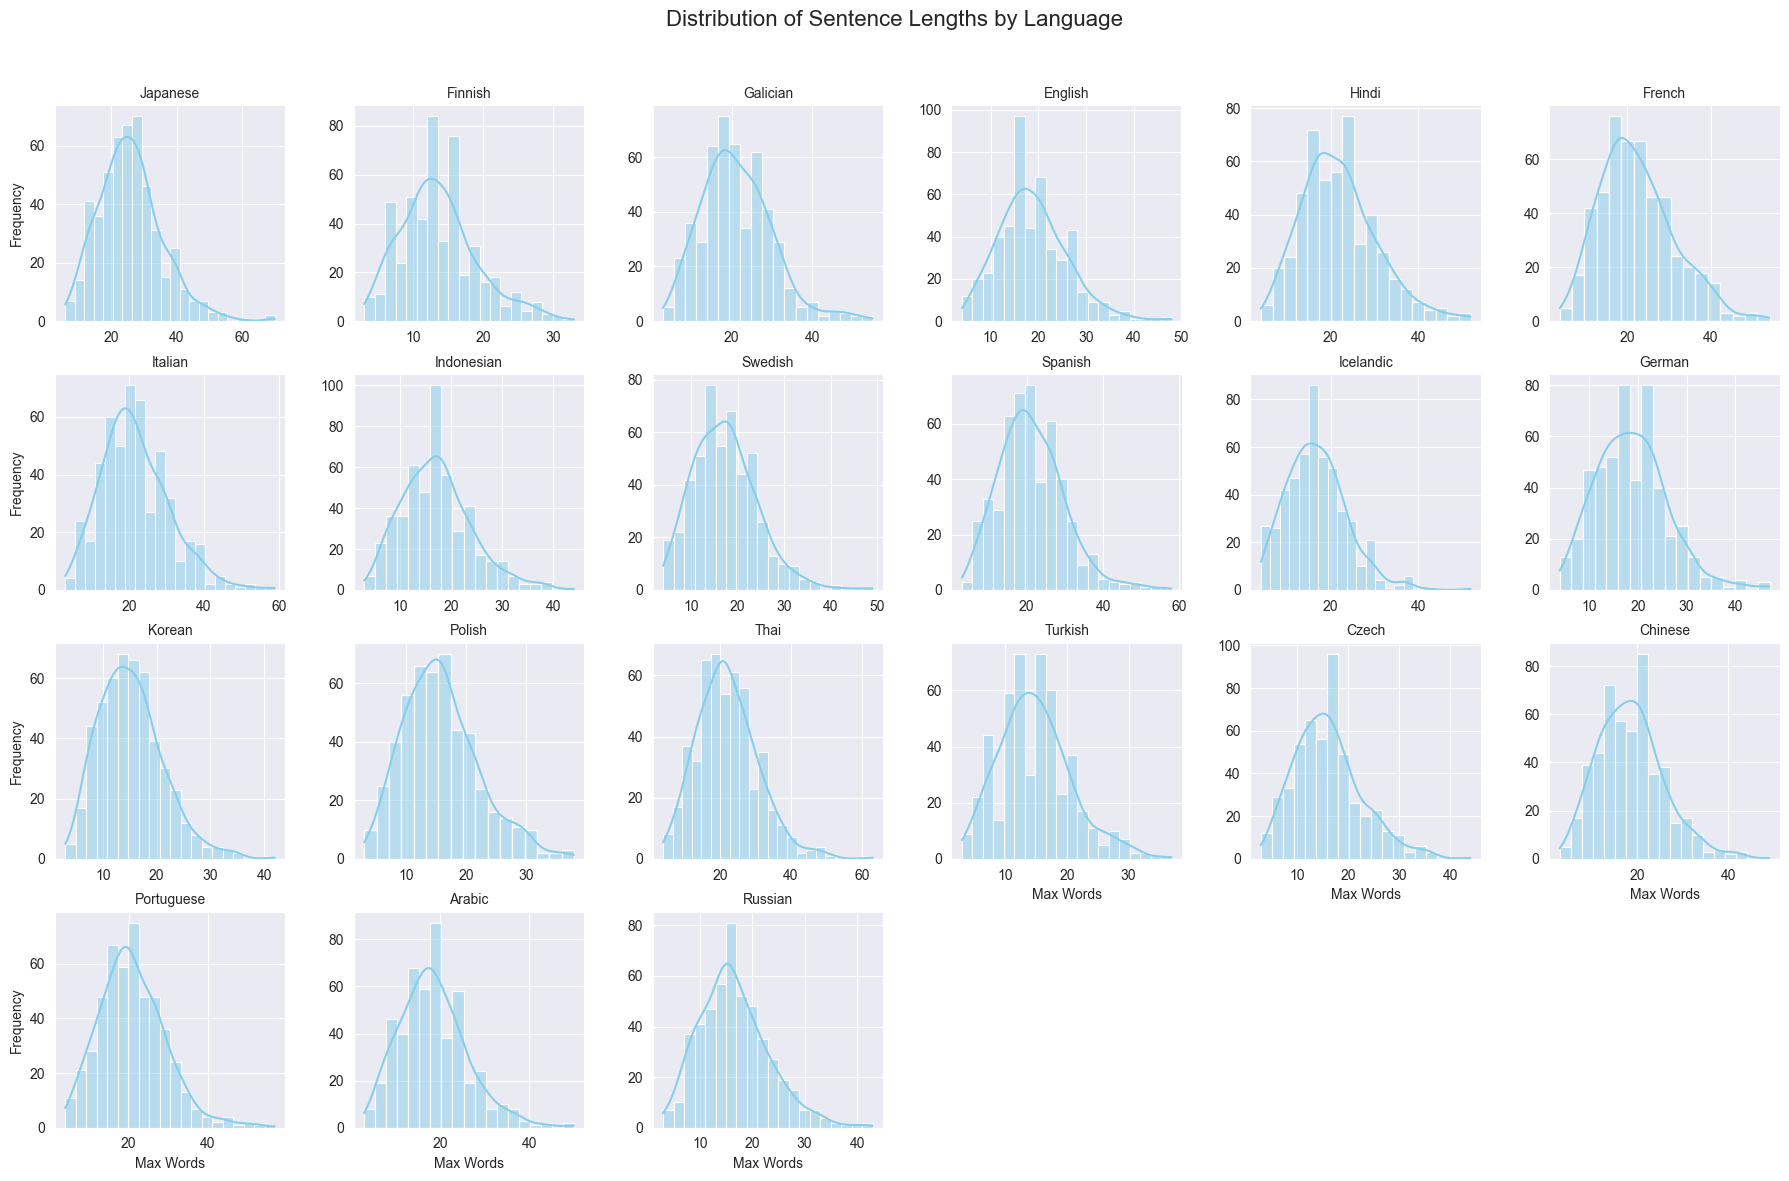

In [7]:
g = sns.FacetGrid(data, col="language", col_wrap=6, sharex=False, sharey=False)

g.map(sns.histplot, "n", kde=True, color="skyblue")

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Max Words", "Frequency")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of Sentence Lengths by Language", fontsize=16)

plt.show()

Next we can check the important word count statistics for an average sentence of every language in an integrated plot:

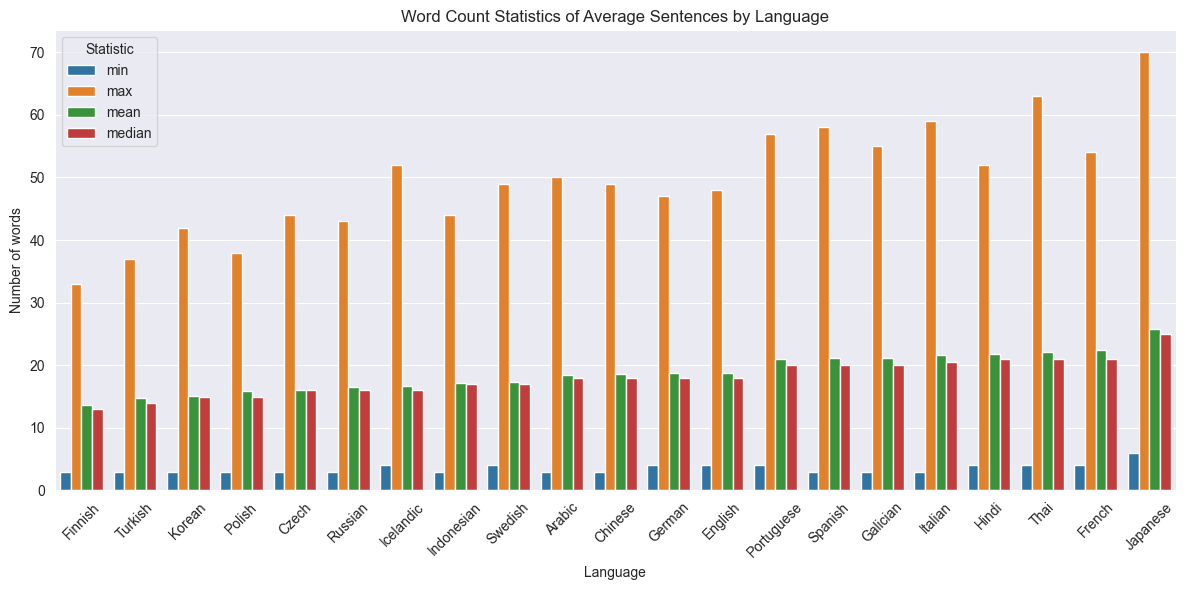

In [8]:
agg_language_df = data.groupby('language')['n'].agg(['min', 'max', 'mean', 'median']).reset_index().sort_values(by='mean')

melted = agg_language_df.melt(id_vars='language', var_name='Statistic', value_name='Value')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='language', y='Value', hue='Statistic')

plt.title('Word Count Statistics of Average Sentences by Language')
plt.ylabel('Number of words')
plt.xlabel('Language')
plt.legend(title='Statistic')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Noticable insights:
- Japanese has on average the highest word count per sentence with $25.8$ while Finnish has the lowest word count with $13.5$. This can be explained by finnish packing a lot of meaning into single words and japanese using a lot of separate words for the same meaning
- Polish, Czech and Russian have similar sentence statistics since they stem from the same language family of slavic languages
- German and English almost have identical statistics since they are both Germanic languages
- Portuguese, Spanish, Italian, and Galician also have similar statistics which can explained from them being romance languages, meaning they descend from Latin.


## Dataset preparation
Now the dataset will be transformed into a training set suitable for binary classification models using centralities as
vertex features

A function is created that transform an edge list into a networkx graph calculating the centralities

In [9]:
def centralities(edgelist):
    T = nx.from_edgelist(edgelist)
    degree = nx.degree_centrality(T)
    closeness = nx.closeness_centrality(T)
    harmonic = nx.harmonic_centrality(T)
    betweeness = nx.betweenness_centrality(T,seed=1)
    load = nx.load_centrality(T)
    pagerank = nx.pagerank(T)
    eigenvector = nx.eigenvector_centrality_numpy(T)
    katz = nx.katz_centrality_numpy(T)
    information = nx.information_centrality(T)
    current_flow_betweenness = nx.current_flow_betweenness_centrality(T)
    percolation = nx.percolation_centrality(T)
    second_order = nx.second_order_centrality(T)
    laplacian = nx.laplacian_centrality(T)
    return {v: (degree[v], closeness[v], harmonic[v], betweeness[v],
                load[v], pagerank[v], eigenvector[v], katz[v], information[v],
                current_flow_betweenness[v], percolation[v],
                second_order[v], laplacian[v]) for v in T}

Now we iterate over each row of the training data, transforming it into a graph and calculating the centralities for every node. The new binary dataset contains the features of `language`, `sentence`,`n`, `vertex`, the various centrality scores and `is_root` (which takes values of 0 or 1 if the particular node is a root node). Since we lose all the information regarding the edges, we decided to use as many centrality measures as possible to retain as much of the semantic information as possible:

In [10]:
columns = ['language', 'sentence', 'vertex', 'n',
           'degree', 'closeness', 'harmonic', 'betweeness', 'load', 'pagerank',
           'eigenvector', 'katz', 'information', 'current_flow_betweeness',
           'percolation', 'second_order', 'laplacian', 'is_root']
binary_data_list = []
# Saving column of edges as a list instead of a string
data['edgelist'] = data['edgelist'].apply(ast.literal_eval)

for row in data.itertuples(index=False):
    for node, (degree, closeness, harmonic, betweeness, load,
              pagerank, eigenvector, katz, information, current_flow_betweeness,
              percolation, second_order, laplacian) in centralities(row.edgelist).items():
        new_row = {'language': row.language,
                   'sentence': row.sentence,
                   'vertex': node,
                   'n': row.n,
                   'degree': degree,
                   'closeness': closeness,
                   'harmonic': harmonic,
                   'betweeness': betweeness,
                   'load': load,
                   'pagerank': pagerank,
                   'eigenvector': eigenvector,
                   'katz': katz,
                   'information': information,
                   'current_flow_betweeness': current_flow_betweeness,
                   'percolation': percolation,
                   'second_order': second_order,
                   'laplacian': laplacian,
                   'is_root': 1 if node == row.root else 0}
        binary_data_list.append(new_row)

expanded_data = pd.DataFrame(binary_data_list, columns=columns)
expanded_data.head(5)

,language,sentence,vertex,n,degree,closeness,harmonic,betweeness,load,pagerank,eigenvector,katz,information,current_flow_betweeness,percolation,second_order,laplacian,is_root
0,Japanese,2,6,23,0.090909,0.159420,5.823846,0.090909,0.090909,0.048565,0.149505,0.209086,0.007246,0.090909,0.090909,98.762341,0.101449,0
1,Japanese,2,4,23,0.045455,0.138365,4.561122,0.000000,0.000000,0.027162,0.068517,0.188298,0.006289,0.000000,0.000000,112.481110,0.043478,0
2,Japanese,2,2,23,0.136364,0.184874,6.991703,0.255411,0.255411,0.066901,0.257706,0.228660,0.008403,0.255411,0.255411,84.451169,0.159420,0
3,Japanese,2,23,23,0.045455,0.157143,5.157179,0.000000,0.000000,0.025477,0.118104,0.190256,0.007143,0.000000,0.000000,100.149888,0.057971,0
4,Japanese,2,20,23,0.090909,0.211538,7.146825,0.311688,0.311688,0.042552,0.294710,0.213357,0.009615,0.311688,0.311688,71.147734,0.130435,0


Next we can normalize the centrality measures of training data but within the same sentence group of the same language:
- Different languages mean different trees (in word order or number of words) and thus centrality values can't be compared directly across languages
- Different sentences also mean different trees



In [11]:
centrality_cols = [
    'degree', 'closeness', 'harmonic', 'betweeness', 'load', 'pagerank', 
    'eigenvector', 'katz', 'information', 'current_flow_betweeness', 
    'percolation', 'second_order', 'laplacian'
]

# Function to apply StandardScaler in each sentence & language group
def scale_within_sentence(group):
    scaler = StandardScaler()
    group[centrality_cols] = scaler.fit_transform(group[centrality_cols])
    return group

normalized_expanded_data = expanded_data.groupby(['language', 'sentence'], group_keys=False).apply(scale_within_sentence).reset_index(drop=True)
normalized_expanded_data.to_csv('../data/normalized_expanded_train.csv')
normalized_expanded_data.head(5)

C:\Users\stef4\AppData\Local\Temp\ipykernel_1852\2028615403.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_expanded_data = expanded_data.groupby(['language', 'sentence'], group_keys=False).apply(scale_within_sentence).reset_index(drop=True)


,language,sentence,vertex,n,degree,closeness,harmonic,betweeness,load,pagerank,eigenvector,katz,information,current_flow_betweeness,percolation,second_order,laplacian,is_root
0,Japanese,2,6,23,0.133038,-0.558160,-0.308023,-0.676962,-0.676962,0.409538,-0.327923,0.074694,-0.558160,-0.676962,-0.676962,0.489782,-0.031273,0
1,Japanese,2,4,23,-1.396899,-1.111953,-1.442852,-1.126101,-1.126101,-1.313638,-1.131636,-1.460142,-1.111953,-1.126101,-1.126101,1.149235,-1.469827,0
2,Japanese,2,2,23,1.662975,0.111311,0.741550,0.135764,0.135764,1.885752,0.745846,1.519954,0.111311,0.135764,0.135764,-0.198147,1.407281,0
3,Japanese,2,23,23,-1.396899,-0.618060,-0.907167,-1.126101,-1.126101,-1.449223,-0.639537,-1.315616,-0.618060,-1.126101,-1.126101,0.556481,-1.110188,0
4,Japanese,2,20,23,0.133038,0.812630,0.880961,0.413803,0.413803,-0.074579,1.113070,0.390094,0.812630,0.413803,0.413803,-0.837635,0.688004,0
